In [ ]:
!pip install transformers
!pip install underthesea
!pip install torch torchvision
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
import pandas as pd


zip_path = "data/data - data.csv.zip"

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    csv_filename = [f for f in zip_ref.namelist() if f.endswith('.csv')][0]

    with zip_ref.open(csv_filename) as csv_file:
        df = pd.read_csv(csv_file)
df.drop(columns=['Unnamed: 3'], inplace=True)

## Trực quan dữ liệu:

In [4]:
df.head(5)

,comment,label,rate
0,Áo bao đẹp ạ!!,POS,5
1,Tuyệt vời !,POS,5
2,2day ao khong giong trong.,NEG,1
3,"Mùi thơm,bôi lên da mềm da.",POS,5
4,"Vải đẹp, dày dặn.",POS,5


In [5]:
df.describe()

,rate
count,31460.000000
mean,3.736840
std,1.382483
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31460 entries, 0 to 31459
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  31460 non-null  object
 1   label    31460 non-null  object
 2   rate     31460 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 737.5+ KB


['POS' 'NEG' 'NEU']
label
POS    20093
NEG     6669
NEU     4698
Name: count, dtype: int64


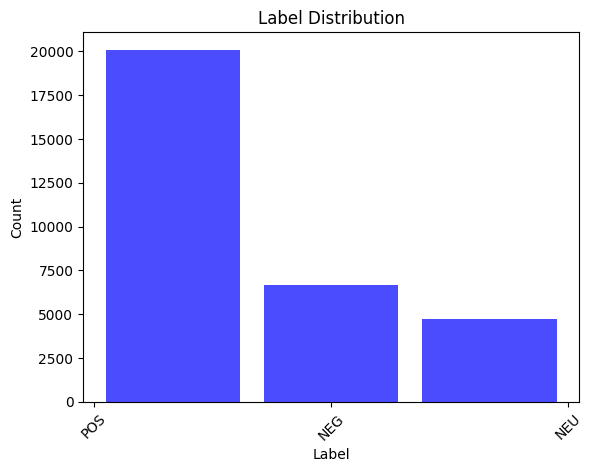

In [7]:
import matplotlib.pyplot as plt
print(df['label'].unique())
print(df['label'].value_counts())
plt.hist(df['label'], bins=len(df['label'].unique()), color='blue', alpha=0.7, rwidth=0.85)
plt.xticks(rotation=45)
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

## Tiền Xử lý dữ liệu
- Tiền xử lý dữ liệu ở đây em sẽ tiến hành các bước như sau:
    - Loại bỏ các số.
    - Loại bỏ các số.
    - Loại bỏ các dấu câu.
    - Loại bỏ khoảng trắng thừa.
    - Bỏ bớt các chữ cái giống nhau liên tiếp (aaaaa -> a).
    - Tách từ tiếng việt sử dụng thư viện underthesea có sẵn.
    - Chuẩn hóa dữ liệu.

- Nói một chút về 1 điểm trong bước này:
    - Thư viện underthesea dùng để làm gì? tại sao không tách bằng split lại thực hiện tách bằng under: `VN_tokenizer` có vai trò rất quan trọng trong bước tiền xử lý văn bản `Tiếng Việt`: khi tách từ bằng `VN_tokenizer` giúp tách thành các cụm từ có nghĩa (ví dụ: "học sinh giỏi" thành ["học sinh", "giỏi"] nghĩa là một từ được xem là hoàn chỉnh là từ "học sinh") đây là bước cực kỳ quan trong vì tiếng việt không có khoảng trắng rõ ràng giữa các từ như tiếng anh.

In [8]:
from vncorenlp import VnCoreNLP
import os
import underthesea

# Đưa về kiểu chữ thường
def text_lower(text):
    return text.lower()
# Loại bỏ các con số
def remove_numbers(text):
    return ''.join([i for i in text if not i.isdigit()])
# Loại bỏ các dấu câu
def remove_punctuation(text):
    text = text.replace(",", " ").replace(".", " ") \
    .replace(";", " ").replace("“", " ") \
    .replace(":", " ").replace("”", " ") \
    .replace('"', " ").replace("'", " ") \
    .replace("!", " ").replace("?", " ") \
    .replace("-", " ").replace("?", " ")
    return text
# Loại bỏ khoảng trắng thừa
def remove_extra_whitespace(text):
    return ' '.join(text.split())
# Loại bỏ các chữ cái giống nhau liên tiếp
def remove_repeated_characters(text):
    return ''.join([text[i] for i in range(len(text)) if i == 0 or text[i] != text[i-1]])
# Loại bỏ các ký tự đặc biệt
def remove_special_characters(text):
    return ''.join([i for i in text if i.isalnum() or i.isspace()])
# Tách từ tiếng việt sử dụng thư viện underthesea
def VN_tokenize(text):
    return underthesea.word_tokenize(text, format="text")

Trong lúc thu thập dữ liệu em sẽ xử lý các teencode, viết tắt về nghĩa tương đương của chúng và danh sách này được lưu trong file `teencode-mean.py`:

In [9]:
import teencode_mean

def Util(text):
    text = text.split()
    length = len(text)
    for i in range(length):
        if text[i] in list(teencode_mean.teencodes.keys()):
            text[i] = teencode_mean.teencodes[text[i]]
    return ' '.join(text)


- Lọc các biểu tượng

In [10]:
import re
emoji_pattern = re.compile("["
                u"\U0001F600-\U0001F64F"
                u"\U0001F300-\U0001F5FF"
                u"\U0001F680-\U0001F6FF"
                u"\U0001F1E0-\U0001F1FF"
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                u"\ufe0f"
    "]+", flags=re.UNICODE) # Unicode emojis.

- Tổng hợp lại tất cả các bước lọc data

In [11]:
def Text_PreProcessing_util(data):
    result_1 = []
    for i in data:
        i = str(i)
        text = VN_tokenize(i)
        text = text_lower(text)
        text = re.sub(emoji_pattern, " ", text)
        text = remove_punctuation(text)
        text = remove_extra_whitespace(text)
        text = remove_repeated_characters(text)
        text = Util(text)
        # text = remove_VN_stopwords(i)
        text = remove_numbers(text)
        result_1.append(text)
    return result_1

### Load data

In [19]:
from sklearn.model_selection import train_test_split

X_data = df["comment"]
Y_data = df["label"]
Y_data = Y_data.replace({"POS": 0, "NEU": 1, "NEG": 2})
X_data = Text_PreProcessing_util(X_data)

### load model

In [20]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

train_texts, val_texts, train_labels, val_labels = train_test_split(
    X_data,
    Y_data,
    test_size=0.2,
    random_state=42)
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


### Tạo Databaset và DataLoader

In [16]:
import torch

class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Tạo Dataset
train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)



In [17]:
from transformers import AutoModelForSequenceClassification

# Load model
model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels=3)

from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    learning_rate=3e-5,
    logging_dir='./logs',
    logging_steps=100,
    max_grad_norm=1.0
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Train mô hình
trainer.train()


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: duyphuc2425 (duyphuc2425-cargurus) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
100,0.774100
200,0.590400
300,0.548600
400,0.542000
500,0.531800
600,0.529600
700,0.511400
800,0.541000
900,0.528400
1000,0.508500


TrainOutput(global_step=9438, training_loss=0.39104713881311337, metrics={'train_runtime': 3313.7636, 'train_samples_per_second': 45.57, 'train_steps_per_second': 2.848, 'total_flos': 7993007405038656.0, 'train_loss': 0.39104713881311337, 'epoch': 6.0})

### Load PhoBert

#### Lưu mô hình

In [18]:
model.save_pretrained("./sentiment_model_phobert")
tokenizer.save_pretrained("./sentiment_model_phobert")

('./sentiment_model_phobert/tokenizer_config.json',
 './sentiment_model_phobert/special_tokens_map.json',
 './sentiment_model_phobert/vocab.txt',
 './sentiment_model_phobert/bpe.codes',
 './sentiment_model_phobert/added_tokens.json')

### Đánh giá sau huấn luyện

In [32]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.evaluate()

{'eval_loss': 0.6354825496673584,
 'eval_model_preparation_time': 0.0049,
 'eval_accuracy': 0.8005403687221869,
 'eval_f1': 0.679933115590285,
 'eval_precision': 0.6894125149022404,
 'eval_recall': 0.6752262041898316,
 'eval_runtime': 44.556,
 'eval_samples_per_second': 141.216,
 'eval_steps_per_second': 2.222}

#### Đánh giá bằng load mô hình

In [23]:
from transformers import pipeline
from sentence_transformers import SentenceTransformer, util
from sentence_transformers.util import cos_sim
import torch

model = SentenceTransformer('all-MiniLM-L6-v2') 
sentiment_pipeline = pipeline("text-classification", model="phucgiacat/sentiment-vietnamese-phobert", tokenizer="phucgiacat/sentiment-vietnamese-phobert")

Device set to use cpu


              precision    recall  f1-score   support

         POS       0.88      0.92      0.90      3981
         NEU       0.43      0.34      0.38       978
         NEG       0.74      0.75      0.74      1333

    accuracy                           0.79      6292
   macro avg       0.68      0.67      0.67      6292
weighted avg       0.78      0.79      0.79      6292



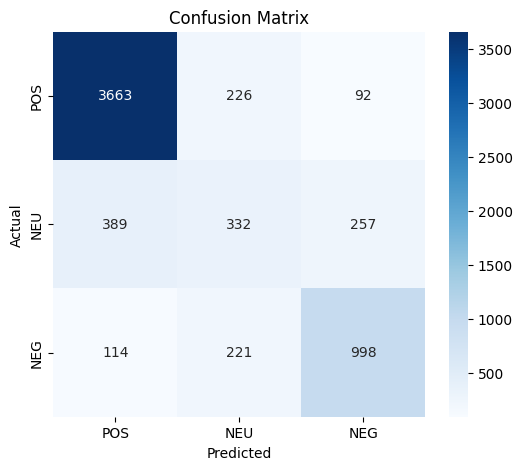

In [27]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_sentiment_model(sentiment_pipeline, X_val, y_val, label_names=["POS", "NEU", "NEG"]):
    # Dự đoán nhãn
    preds = sentiment_pipeline(X_val, truncation=True, max_length=256)

    # Chuyển label từ 'LABEL_0' -> 0, 'LABEL_1' -> 1, ...
    y_pred = [int(pred['label'].split('_')[-1]) for pred in preds]

    # Confusion matrix
    cm = confusion_matrix(y_val, y_pred)

    # Báo cáo chi tiết
    print(classification_report(y_val, y_pred, target_names=label_names))

    # Vẽ heatmap
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
evaluate_sentiment_model(sentiment_pipeline, val_texts, val_labels)